# Tuning a scikit-learn estimator with `skopt`

Gilles Louppe, July 2016 <br />
Katie Malone, August 2016

If you are looking for a `GridSearchCV` replacement checkout [the `BayesSearchCV` example](sklearn-gridsearchcv-replacement.ipynb) instead.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Problem statement

Tuning the hyper-parameters of a machine learning model is often carried out using an exhaustive exploration of (a subset of) the space all hyper-parameter configurations (e.g., using `sklearn.model_selection.GridSearchCV`), which often results in a very time consuming operation. 

In this notebook, we illustrate how to couple `gp_minimize` with sklearn's estimators to tune hyper-parameters using sequential model-based optimisation, hopefully resulting in equivalent or better solutions, but within less evaluations. 

Note: scikit-optimize provides a dedicated interface for estimator tuning via `BayesSearchCV` class which has a similar interface to those of `GridSearchCV`. This class uses functions of skopt to perform hyperparameter search efficiently. For example usage of this class, see [the `BayesSearchCV` example](sklearn-gridsearchcv-replacement.ipynb) example notebook.

## Objective 

To tune the hyper-parameters of our model we need to define a model, decide which parameters to optimize, and define the objective function we want to minimize.

In [2]:
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

boston = load_boston()
X, y = boston.data, boston.target
n_features = X.shape[1]

# gradient boosted trees tend to do well on problems like this
reg = GradientBoostingRegressor(n_estimators=50, random_state=0)

Next, we need to define the bounds of the dimensions of the search space we want to explore and pick the objective. In this case the cross-validation mean absolute error of a gradient boosting regressor over the Boston dataset, as a function of its hyper-parameters.

In [3]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args


# The list of hyper-parameters we want to optimize. For each one we define the bounds,
# the corresponding scikit-learn parameter name, as well as how to sample values
# from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(1, 5, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set scikit-learn
# estimator parameters
@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

## Optimize all the things!

With these two pieces, we are now ready for sequential model-based optimisation. Here we use gaussian process-based optimisation.

In [4]:
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

"Best score=%.4f" % res_gp.fun

'Best score=2.8941'

In [5]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4]))

Best parameters:
- max_depth=2
- learning_rate=0.157830
- max_features=13
- min_samples_split=2
- min_samples_leaf=1


## Convergence plot

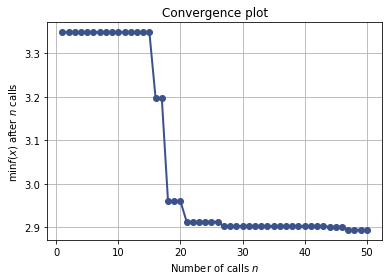

In [6]:
from skopt.plots import plot_convergence

plot_convergence(res_gp);